In [266]:
import os
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
from sklearn import metrics

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.layers import Input, Embedding, Dense, Conv2D, MaxPool2D, concatenate
from keras.layers import Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D
from keras.layers import BatchNormalization, InputSpec, add
from keras.optimizers import Adam
from keras.models import Model, load_model
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers, activations
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.utils import Sequence
from sklearn.preprocessing import LabelEncoder
train_df = pd.read_csv('train_2.csv')


In [267]:
# lb = LabelBinarizer()
# y_train = lb.fit_transform(train_df['Label'])
train_df['len'] = train_df['len']/600
train_df['len_last_min'] = train_df['len_last_min']/60
train_df['len_last_5'] = train_df['len_last_5']/300


In [268]:
y = train_df.target_x.values
X = train_df.drop(['target_x','row_id','time_id','stock_id','target_y'],axis = 1)
# X['target_y'].values[X['target_y'] > 0.009] = 0.0031

In [269]:
X

,target,len,len_last_min,len_last_5
0,0.004115,0.501667,0.466667,0.463333
1,0.001268,0.331667,0.366667,0.383333
2,0.002719,0.311667,0.133333,0.226667
3,0.002625,0.198333,0.116667,0.176667
4,0.001901,0.291667,0.183333,0.296667
...,...,...,...,...
428927,0.003338,0.515000,0.533333,0.473333
428928,0.003347,0.370000,0.533333,0.350000
428929,0.003695,0.425000,0.533333,0.556667
428930,0.003375,0.663333,0.616667,0.636667


In [270]:
scale= 100
X[['target']] = X[['target']]*scale
y = y*scale

In [276]:
# (X['target_y']>0.1).any()
from tensorflow import keras
layers = keras.layers
models = keras.models
# Build the model
from keras import backend as K 

# Do some code, e.g. train and save model

# K.clear_session()
# seed_value= 0

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
# os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
# random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
# np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
# tf.random.set_seed(seed_value)
# def rmspe(y_true, y_pred):
#     '''
#     Compute Root Mean Square Percentage Error between two arrays.
#     '''
#     loss = np.sqrt(np.mean(np.square(((y_true - y_pred) / y_true)), axis=0))

#     return loss
from keras import backend as K
def rmspe(y_true, y_pred):
    sume = K.sqrt(K.mean(K.square( (y_true - y_pred) /
          K.clip(K.abs(y_true),K.epsilon(),None) ), axis=-1) )
    return sume
def build_base_model():
    K.clear_session()
    seed_value = 0
    tf.random.set_seed(seed_value)
    os.environ['PYTHONHASHSEED']=str(seed_value)
    random.seed(seed_value)
    np.random.seed(seed_value)
    base_model = models.Sequential()
    base_model.add(layers.Dense(5, input_shape=(4,)))
    # model.add(layers.BatchNormalization())
    base_model.add(layers.Activation('linear'))
#     base_model.add(layers.Dropout(0.2))
#     base_model.add(layers.Dense(112))
#     base_model.add(layers.BatchNormalization())
#     base_model.add(layers.Activation('linear'))
#     base_model.add(layers.Dense(11))
#     base_model.add(layers.BatchNormalization())
#     base_model.add(layers.Activation('linear'))
    # model.add(layers.Dense(512))
    # # model.add(layers.BatchNormalization())
    # model.add(layers.Activation('relu'))
    # model.add(layers.Dense(128))
    # # model.add(layers.BatchNormalization())
    # model.add(layers.Activation('relu'))

    # model.add(layers.Dropout(drop_ratio))
    base_model.add(layers.Dense(1))
    base_model.add(layers.Activation('linear'))

    base_model.compile(loss='mse',
                  optimizer='adam',
                  metrics=[rmspe])
    return base_model

In [277]:
K.epsilon()

1e-07

In [278]:
features = X.columns.tolist()
col_target = 'target_x'

In [281]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback, ReduceLROnPlateau
file_path = "weights_base.best.hdf5"
def benchmark():
    print('_' * 80)
    print("Training: ")
#     print(clf)
#     t0 = time()
    skf = KFold(n_splits=5, random_state=0)
    models, preds, scores = [], [],[]
#     vectorizer = vect(max_df = 0.5)
    i = 0
    for train, test in skf.split(X, y):
#     print(train, test)
#     clf = LogisticRegression(penalty='l1')
#         clf.fit(vectorizer.transform(), data_train.Label.loc[data_train.index.intersection(train)])
#         K.clear_session()
        clf = build_base_model()
        X_train = train_df[features].loc[train_df.index.intersection(train)].values
        X_val = train_df[features].loc[train_df.index.intersection(test)].values
        y_train = train_df[col_target].loc[train_df.index.intersection(train)].values
        y_val = train_df[col_target].loc[train_df.index.intersection(test)].values
#         X_train = vect.transform(X_train).toarray()
#         X_val = vect.transform(X_val).toarray()
#         X_test = vect.transform(test_df.Text).toarray()
        print(str(i)*80)
        i = i+1
        
        
        clf.fit(X_train, y_train,
                    batch_size=100,
                    epochs=10,
                    verbose=1,
                   validation_data = (X_val,y_val),
                   callbacks=[
#               RocAucEvaluation(verbose=True),
              ModelCheckpoint(file_path,    monitor='val_loss', mode='min', save_best_only=True),
              EarlyStopping(patience=10,    monitor="val_loss", mode="min"),
              ReduceLROnPlateau(patience=4, monitor='val_loss', mode='min', cooldown=2, min_lr=1e-7, factor=0.3)])
#         preds.append(clf.predict(X_test))
        models.append(clf)
        scores.append(clf.evaluate(X_val,y_val))
#         y_pred = clf.predict(X)
#         print(rmspe(y/scale,y_pred/scale))
#         coefs.append(clf.coef_[0])
#         clf.fit(X_train, y_train)
#     train_time = time() - t0
#     print("train time: %0.3fs" % train_time)

#     t0 = time()
#     pred = clf.predict(X_test)
#     test_time = time() - t0
#     print("test time:  %0.3fs" % test_time)
#     pred = np.mean(preds,axis = 0)
#     score = metrics.accuracy_score(data_test.Label, pred)
#     print("accuracy:   %0.3f" % score)
    return models, scores


In [282]:
# base_model.evaluate(x_val,y_val)
# train_X.shape
# (y_train == train_y).all()
from __future__ import print_function

import logging
import numpy as np
from optparse import OptionParser
import sys
from time import time
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold,StratifiedKFold,cross_val_score,train_test_split,StratifiedShuffleSplit

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron,LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn.decomposition import PCA
from sklearn import metrics
import pandas as pd
from sklearn.metrics import accuracy_score
base_models,scores = benchmark()

________________________________________________________________________________
Training: 
00000000000000000000000000000000000000000000000000000000000000000000000000000000
Epoch 1/10
3432/3432 [==============================] - 4s 1ms/step - loss: 5.3648e-04 - rmspe: 4.8799 - val_loss: 5.1816e-05 - val_rmspe: 1.8397
Epoch 2/10
3432/3432 [==============================] - 4s 1ms/step - loss: 1.2802e-05 - rmspe: 0.8204 - val_loss: 2.4913e-06 - val_rmspe: 0.2547
Epoch 3/10
3432/3432 [==============================] - 4s 1ms/step - loss: 2.3322e-06 - rmspe: 0.3051 - val_loss: 3.0911e-06 - val_rmspe: 0.2473
Epoch 4/10
3432/3432 [==============================] - 4s 1ms/step - loss: 2.4341e-06 - rmspe: 0.3231 - val_loss: 2.8702e-06 - val_rmspe: 0.2297
Epoch 5/10
3432/3432 [==============================] - 4s 1ms/step - loss: 2.3838e-06 - rmspe: 0.3137 - val_loss: 2.6411e-06 - val_rmspe: 0.3484
Epoch 6/10
3432/3432 [==============================] - 4s 1ms/step - loss: 2.1536e-06 - rmspe: 0

In [265]:
# X.index.intersection(test)
# clf
y_pred_0 = base_models[4].predict(X)
rmspe(y/scale,y_pred_0.reshape(1,-1)[0]/scale)
# 

<tf.Tensor: shape=(), dtype=float64, numpy=0.555363809502127>

In [287]:
# # rmspe(y/scale,X.target_y/100)
# import shap

# # load your data here, e.g. X and y
# # create and fit your model here

# # load JS visualization code to notebook
# shap.initjs()

# # explain the model's predictions using SHAP
# # (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
# explainer = shap.TreeExplainer(base_models[0])
# shap_values = explainer.shap_values(X)

# # visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
# shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

# shap.summary_plot(shap_values, X, plot_type="bar")
# train

,stock_id,time_id,target_x,row_id,target_y,target,len,len_last_min,len_last_5
0,0,5,0.004136,0-5,0.003793,0.004115,0.501667,0.466667,0.463333
1,0,11,0.001445,0-11,0.001438,0.001268,0.331667,0.366667,0.383333
2,0,16,0.002168,0-16,0.003178,0.002719,0.311667,0.133333,0.226667
3,0,31,0.002195,0-31,0.003836,0.002625,0.198333,0.116667,0.176667
4,0,62,0.001747,0-62,0.002299,0.001901,0.291667,0.183333,0.296667
...,...,...,...,...,...,...,...,...,...
428927,126,32751,0.003461,126-32751,0.003037,0.003338,0.515000,0.533333,0.473333
428928,126,32753,0.003113,126-32753,0.003578,0.003347,0.370000,0.533333,0.350000
428929,126,32758,0.004070,126-32758,0.003701,0.003695,0.425000,0.533333,0.556667
428930,126,32763,0.003357,126-32763,0.002707,0.003375,0.663333,0.616667,0.636667


C:\Users\amakr\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\amakr\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


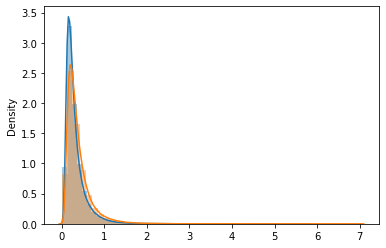

In [259]:
# X.target
import seaborn as sns
sns.distplot((y_pred_0))
sns.distplot(y)

In [208]:
# np.log(y)
# np.log(X.target_y)
(train_df).corr()['target_x']

stock_id       -0.021637
time_id        -0.010331
target_x        1.000000
target_y       -0.000400
target          0.866859
len            -0.054558
len_last_min   -0.048217
len_last_5     -0.049933
Name: target_x, dtype: float64